In [1]:
# to make import as we would be in root directory
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

from lib.autoencoders import TestAutoencoder
import lib.training as training
import lib.utils as utils

c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload

In [4]:
%autoreload

## Loading training dataset

In [5]:
emnist_pages, kmnist_pages = training.load_dataset_pages('clean', 36)

In [6]:
emnist_pages = 1 - emnist_pages
kmnist_pages = 1 - kmnist_pages

In [7]:
emnist_chars = rearrange(emnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)
kmnist_chars = rearrange(kmnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)

In [8]:
fil_emnist_chars, fil_kmnist_chars = training.filter_white_characters(
    emnist_chars, kmnist_chars, threshold=0.1)

Dropped 67.2% characters


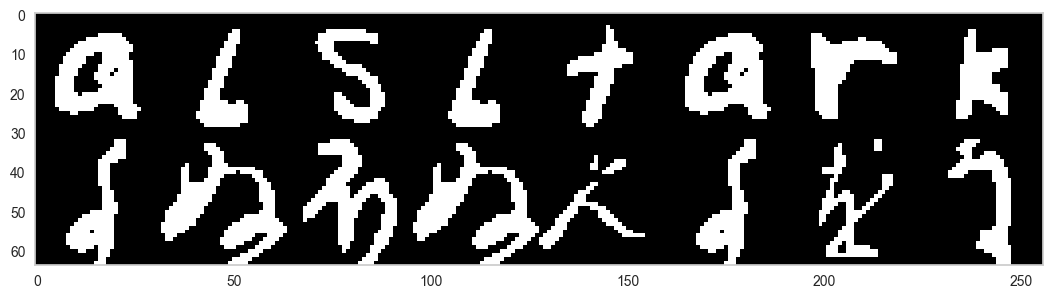

In [9]:
training.show_datasets(fil_emnist_chars, fil_kmnist_chars, samples_count=8)

## EMNIST

In [10]:
emnist_autoencoder = TestAutoencoder('clean_autoencoder_emnist', output_features=30)

In [11]:
# training
emnist_autoencoder.model.fit(fil_emnist_chars, fil_emnist_chars, epochs=2, batch_size=64)

Epoch 1/2
1682/1682 [==============================] - 18s 9ms/step - loss: 0.0030
Epoch 2/2
1682/1682 [==============================] - 14s 8ms/step - loss: 2.5199e-04


In [248]:
emnist_autoencoder.save()

In [249]:
emnist_autoencoder.load()

1/1 [==============================] - 0s 101ms/step


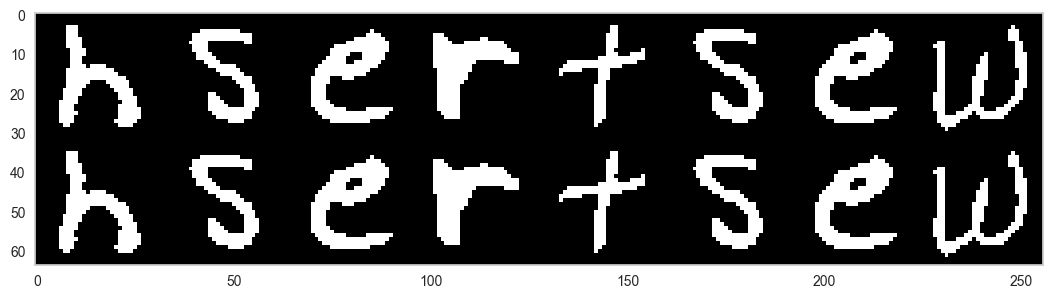

In [12]:
training.test_autoencoder(emnist_autoencoder, fil_emnist_chars, samples_count=8, binarize=True)

In [13]:
encoded_emnist = emnist_autoencoder.encoder.predict(fil_emnist_chars, batch_size=64)

1682/1682 [==============================] - 3s 2ms/step


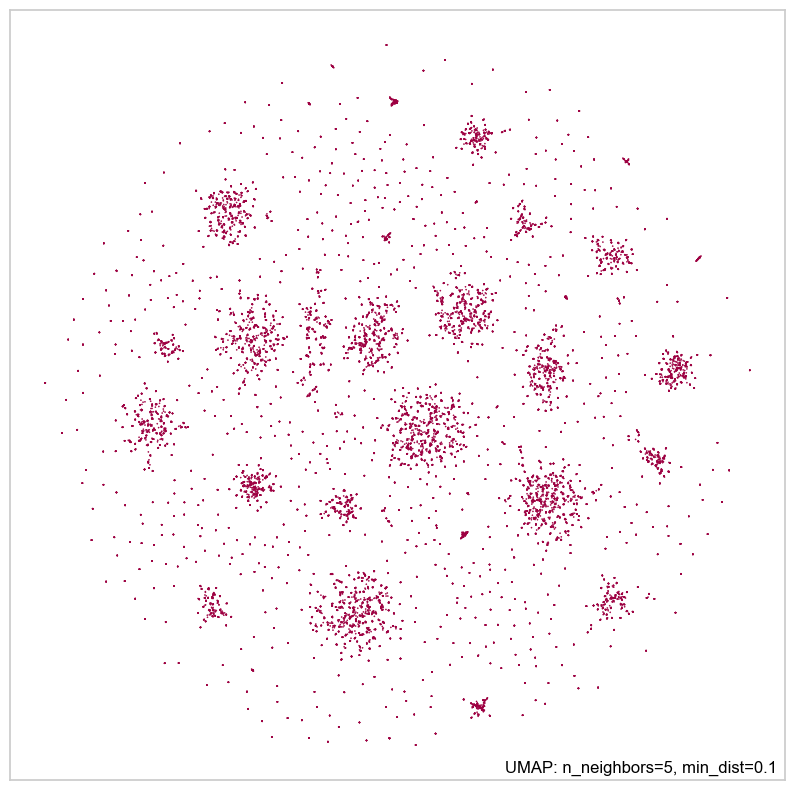

In [14]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.visualize_clusters(encoded_emnist, ax, n_samples=20_000)

Clusters count: 33


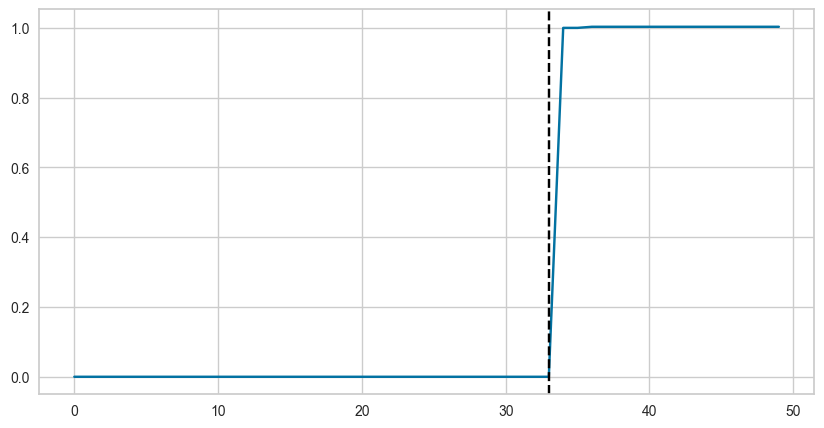

In [15]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
emnist_clusters_no = utils.get_number_of_clusters_with_eigen_values(encoded_emnist, ax, n_samples=3_000)
print('Clusters count:', emnist_clusters_no)

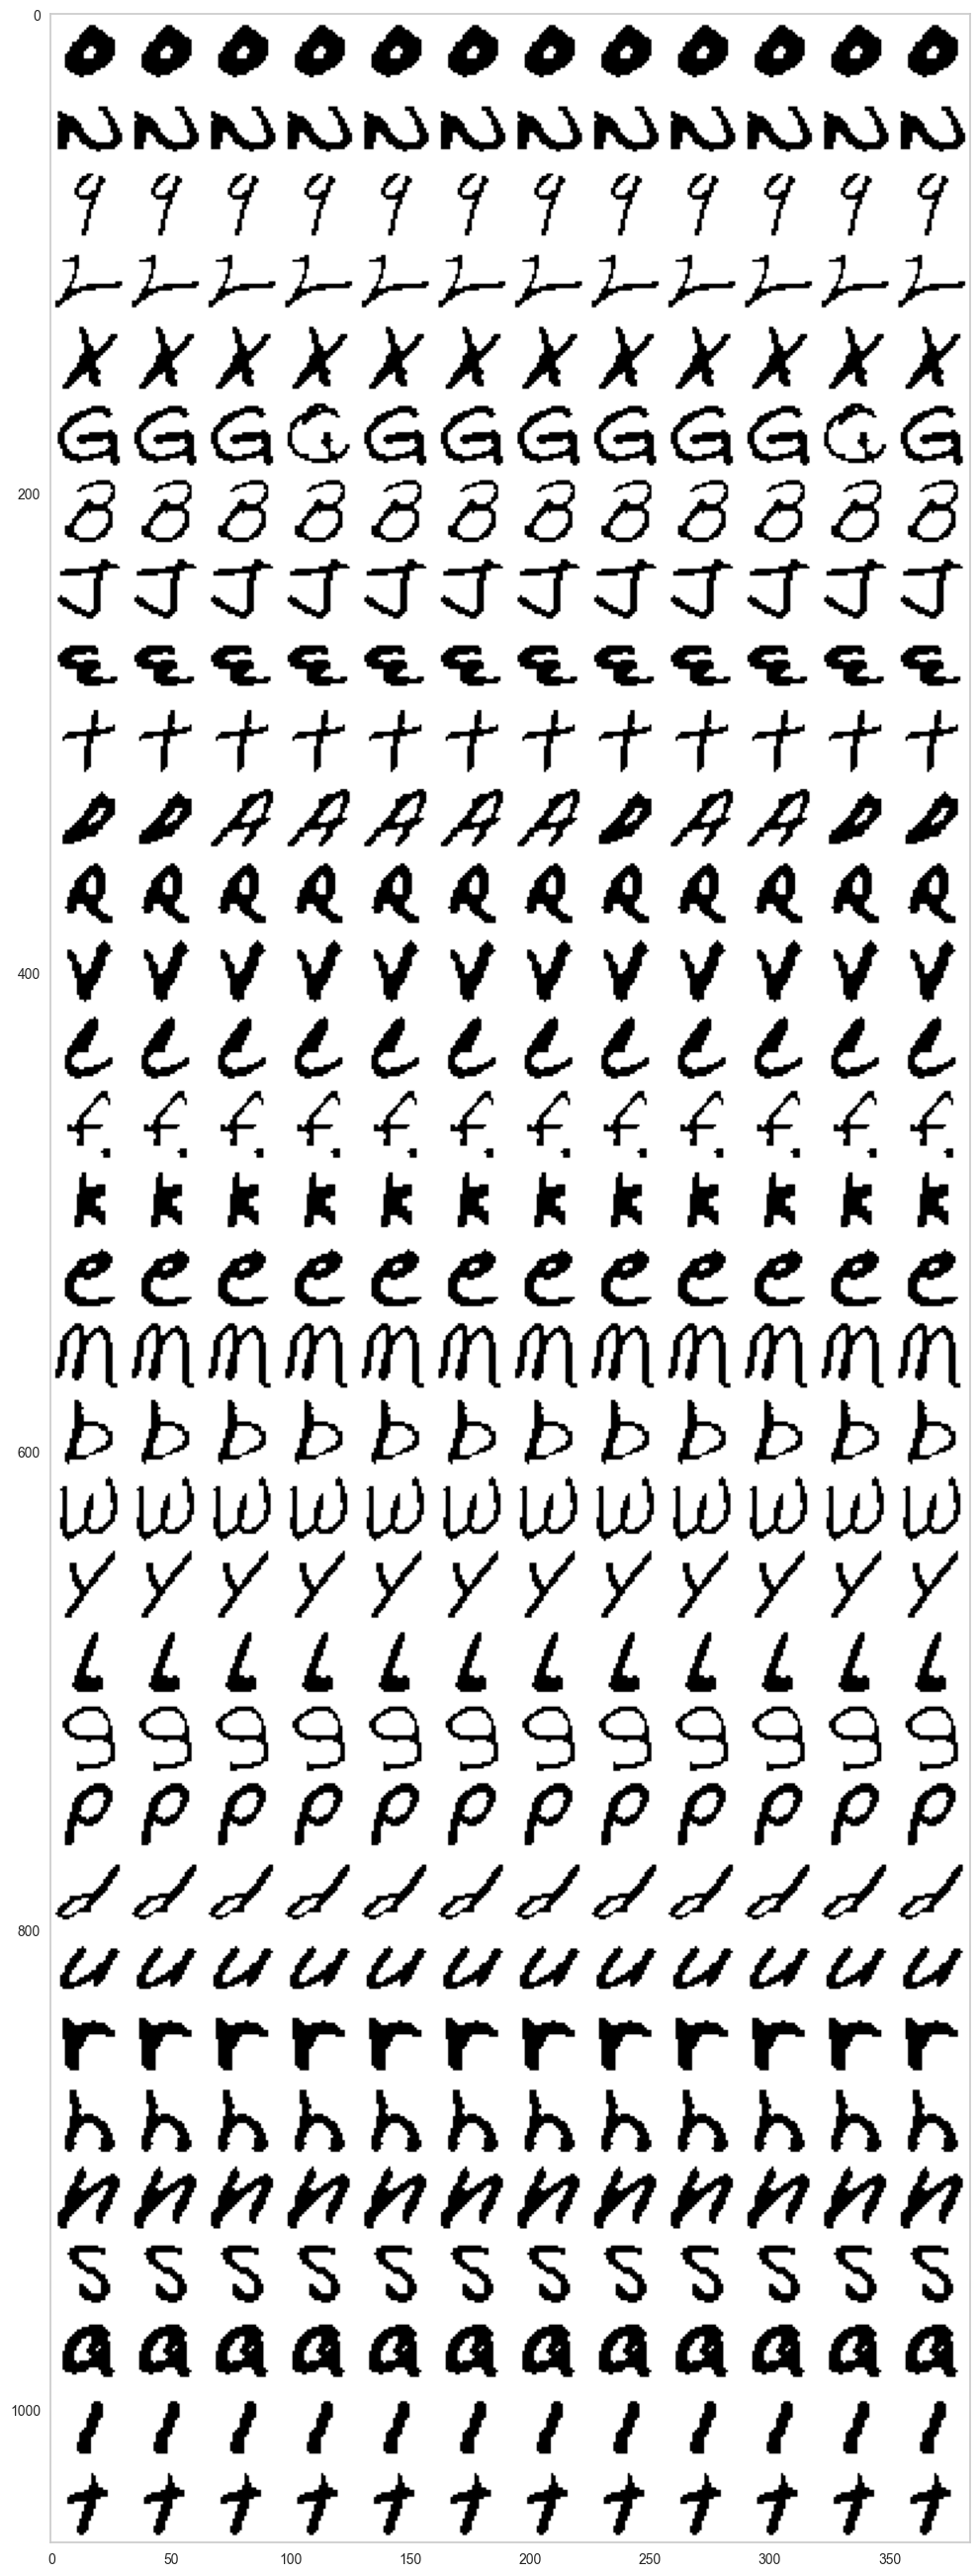

In [16]:
sampled_encoded_emnist = utils.sample(encoded_emnist, n_samples=7_000)
emnist_labels = utils.cluster(sampled_encoded_emnist, emnist_clusters_no)
sorted_encoded_emnist = utils.sort_characters_by_labels(sampled_encoded_emnist, emnist_labels)
_ = utils.visualize_sorted_characters(sorted_encoded_emnist, emnist_autoencoder, binarize=True)

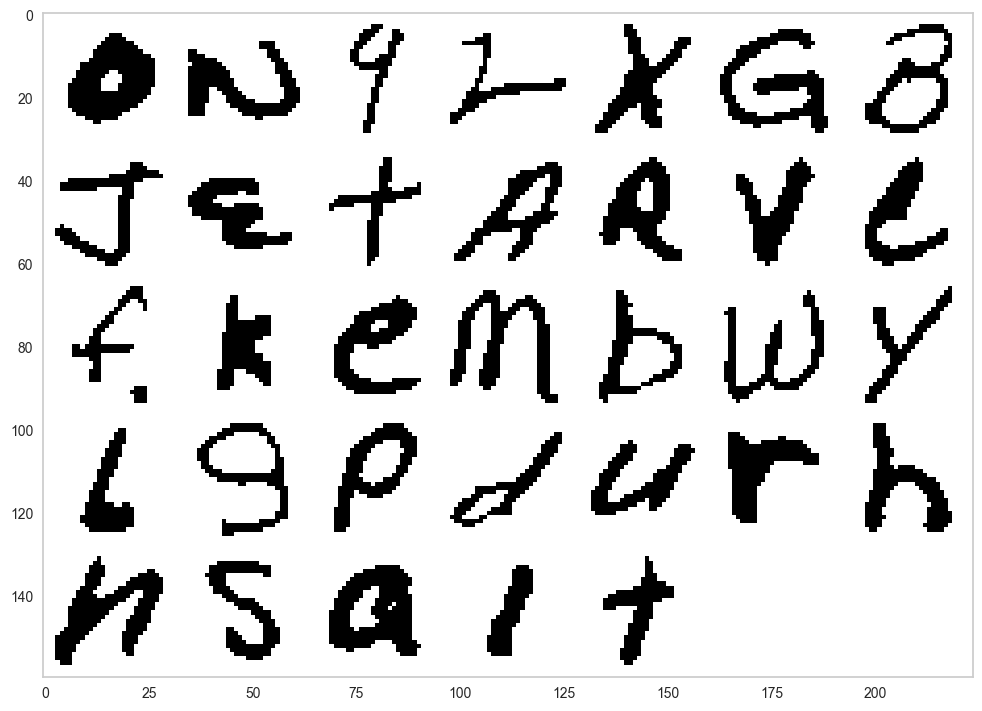

In [17]:
emnist_representatives = training.create_characters_representatives(sorted_encoded_emnist, emnist_autoencoder)
training.show_characters_representatives(emnist_representatives)

In [18]:
emnist_clusters_sizes = [len(class_characters) for class_characters in sorted_encoded_emnist]
emnist_autoencoder.quantities = emnist_clusters_sizes
emnist_autoencoder.characters = emnist_representatives
emnist_autoencoder.save()

## KMNIST

In [19]:
kmnist_autoencoder = TestAutoencoder('clean_autoencoder_kmnist', output_features=30)

In [20]:
# training
kmnist_autoencoder.model.fit(fil_kmnist_chars, fil_kmnist_chars, epochs=2, batch_size=64)

Epoch 1/2
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0037
Epoch 2/2
1682/1682 [==============================] - 14s 8ms/step - loss: 2.3885e-04


In [ ]:
# saving
kmnist_autoencoder.save()

In [320]:
# loading
kmnist_autoencoder.load()

1/1 [==============================] - 0s 84ms/step


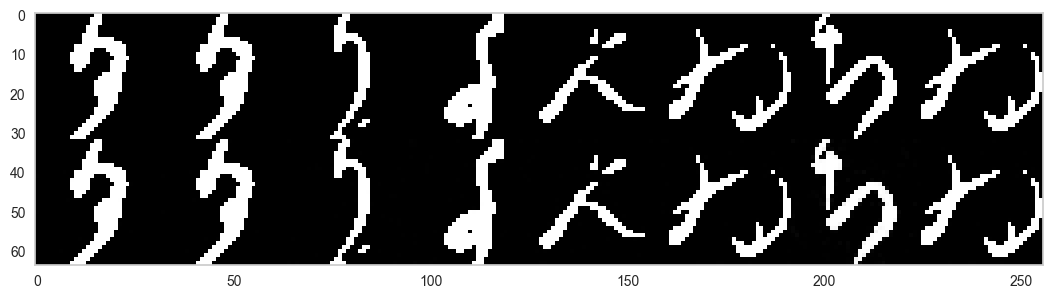

In [21]:
# testing
training.test_autoencoder(kmnist_autoencoder, fil_kmnist_chars, samples_count=8)

In [22]:
encoded_kmnist = kmnist_autoencoder.encoder.predict(fil_kmnist_chars, batch_size=256)

421/421 [==============================] - 1s 2ms/step


c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited at iteration 8 with accuracies 
[2.72138938e-12 1.11682857e-05 5.86390091e-06 5.15648896e-06]
not reaching the requested tolerance 7.510185241699219e-06.
Use iteration 8 instead with accuracy 
5.547169571588104e-06.

  _, diffusion_map = lobpcg(
c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\sklearn\manifold\_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.64393062e-12 1.11682811e-05 5.86390963e-06 5.15648897e-06]
not reaching the requested tolerance 7.510185241699219e-06.
  _, diffusion_map = lobpcg(
c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


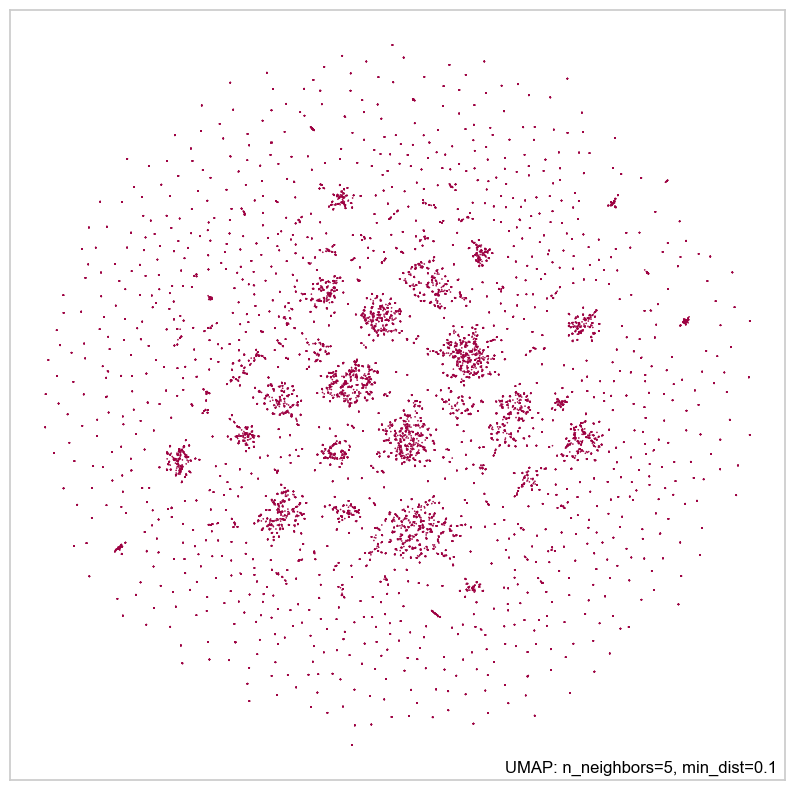

In [23]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.visualize_clusters(encoded_kmnist, ax, n_samples=20_000)

Clusters count: 35


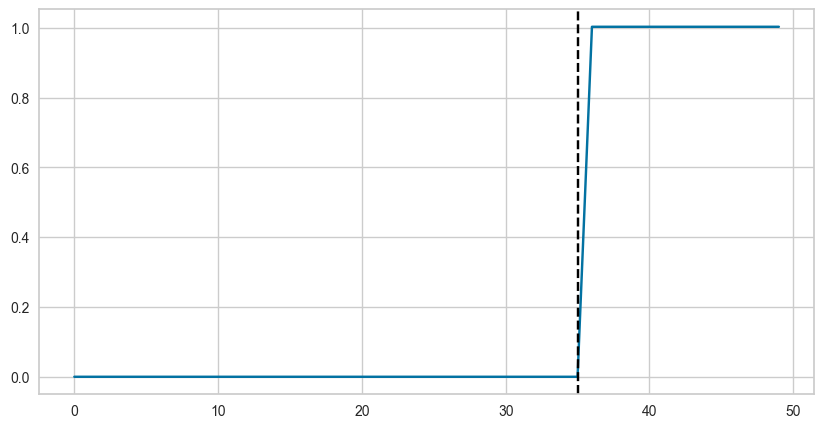

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
kmnist_clusters_no = utils.get_number_of_clusters_with_eigen_values(encoded_kmnist, ax, n_samples=3_000)
print('Clusters count:', kmnist_clusters_no)

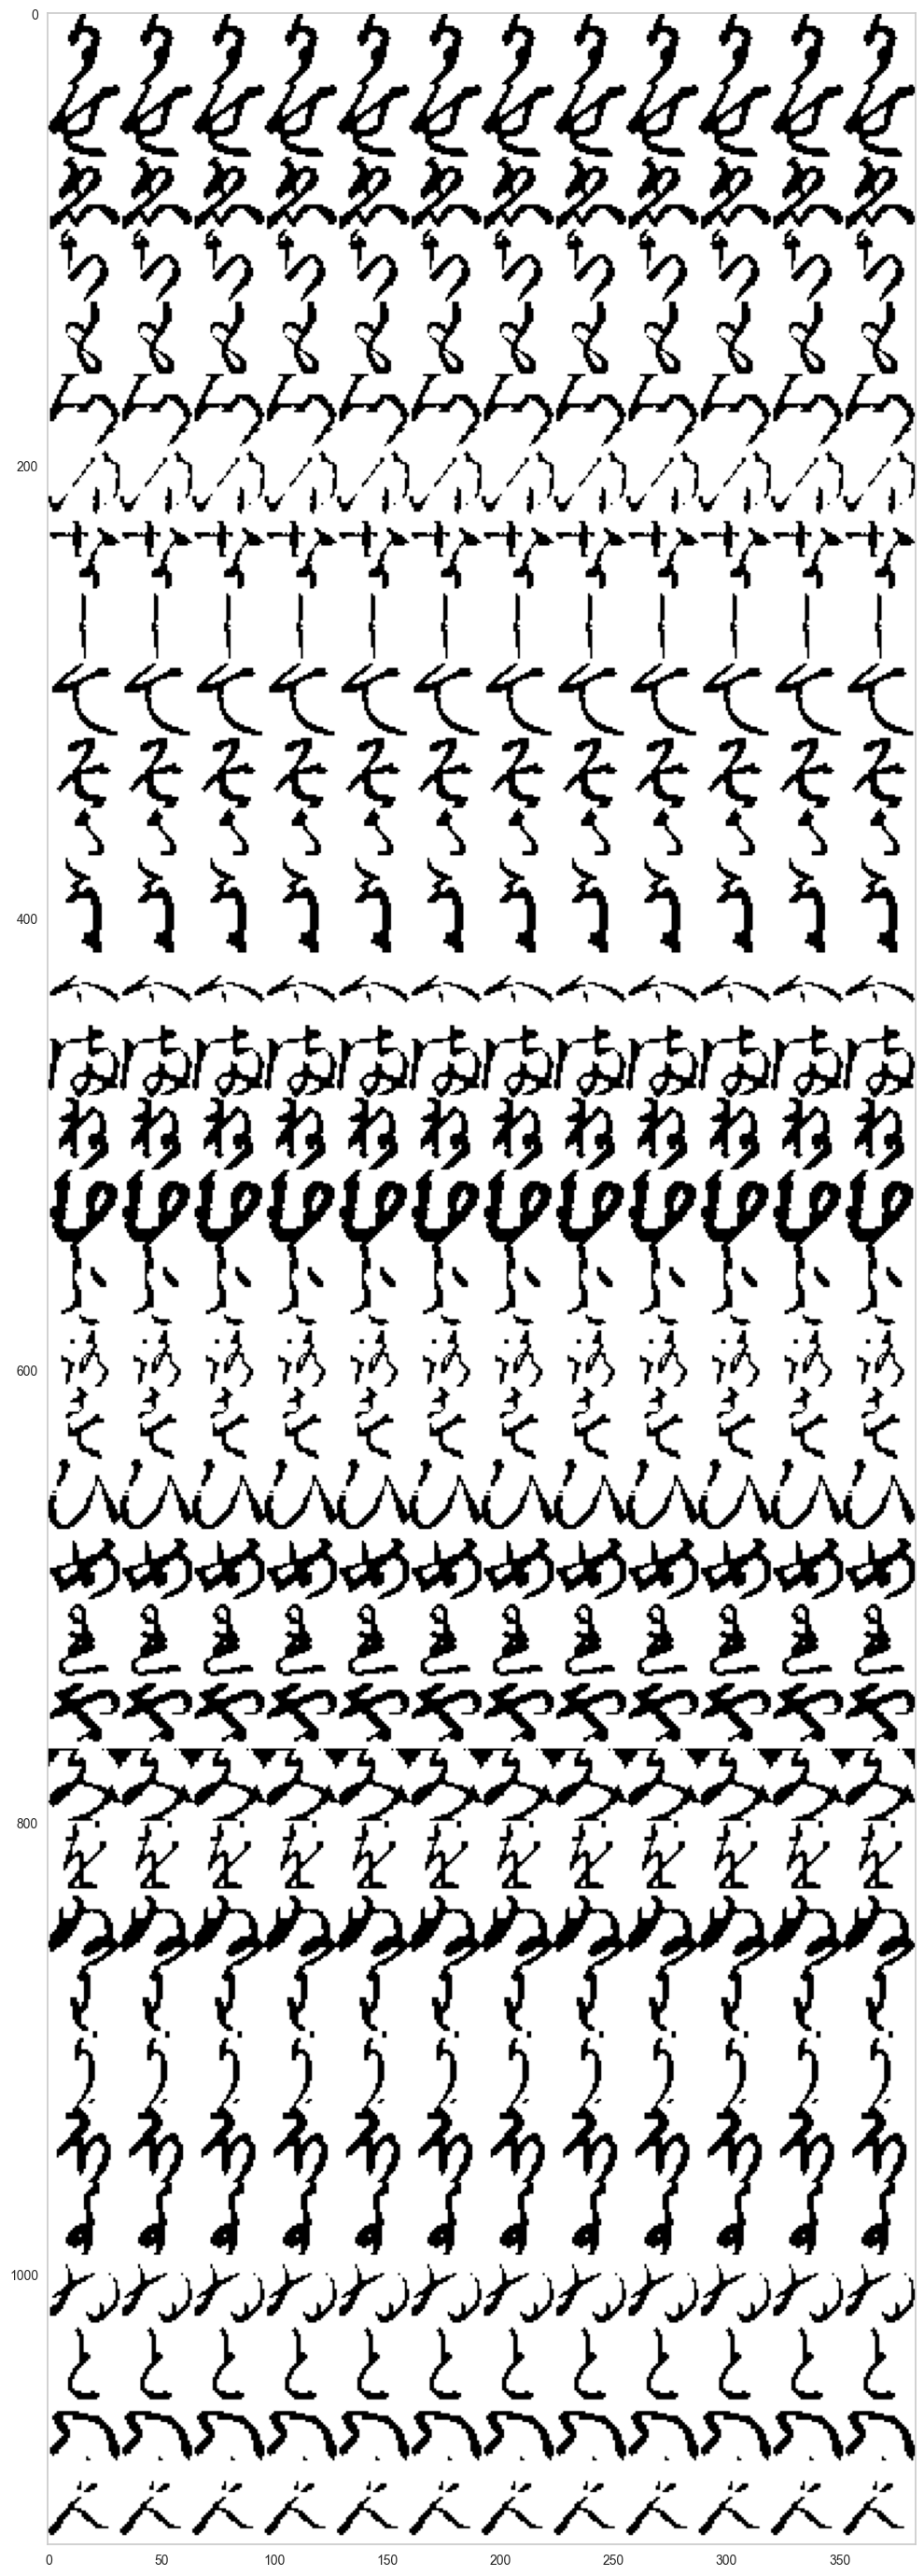

In [25]:
sampled_encoded_kmnist = utils.sample(encoded_kmnist, n_samples=7_000)
kmnist_labels = utils.cluster(sampled_encoded_kmnist, kmnist_clusters_no)
sorted_encoded_kmnist = utils.sort_characters_by_labels(sampled_encoded_kmnist, kmnist_labels)
_ = utils.visualize_sorted_characters(sorted_encoded_kmnist, kmnist_autoencoder, binarize=True)

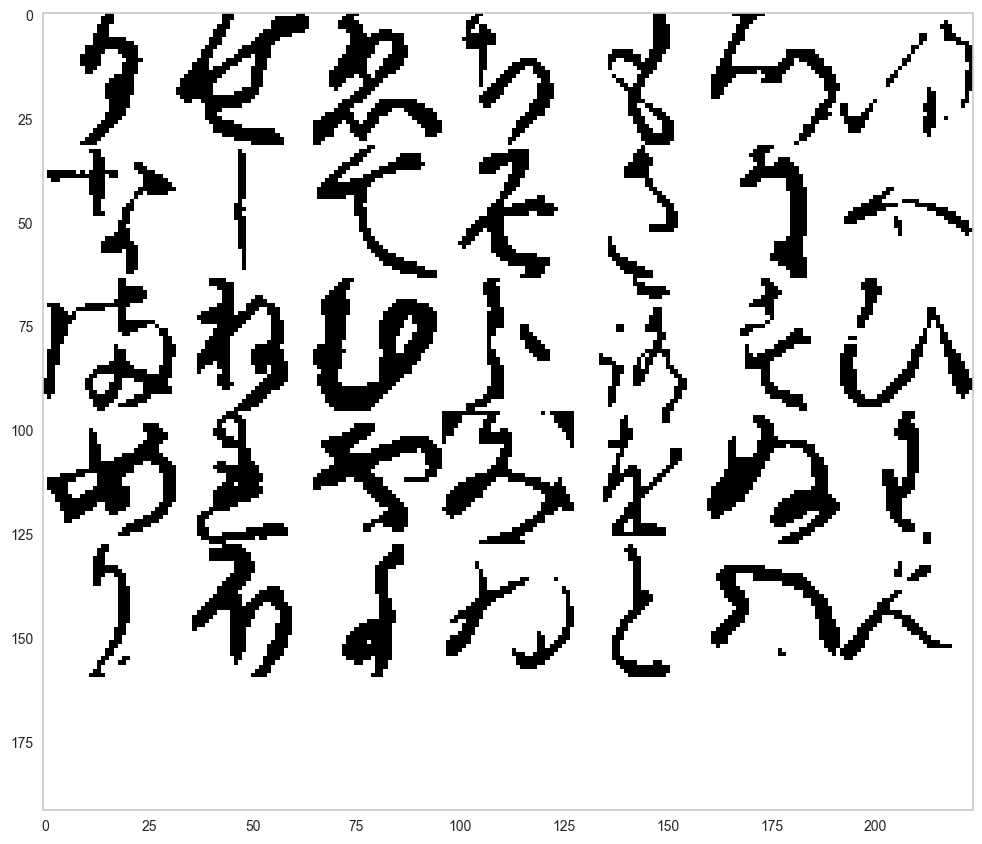

In [26]:
kmnist_representatives = training.create_characters_representatives(sorted_encoded_kmnist, kmnist_autoencoder)
training.show_characters_representatives(kmnist_representatives)

In [27]:
kmnist_clusters_sizes = [len(class_characters) for class_characters in sorted_encoded_kmnist]
kmnist_autoencoder.quantities = kmnist_clusters_sizes
kmnist_autoencoder.characters = kmnist_representatives
kmnist_autoencoder.save()